In [1]:
import os
import random
import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset

import numpy as np 
import pickle
import matplotlib.pyplot as plt
import time
import copy

from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/fcn_timeseries')

In [2]:
X = pickle.load(open('../dataset/train/cross_subject_data_5_subjects.pickle', 'rb'))
y = X['train_y']

X = X['train_x'].astype(np.float32)

label_map = {'imagine_both_feet': 0, 'imagine_both_fist': 1, 'imagine_left_fist': 2, 'imagine_right_fist': 3}
y = np.vectorize(label_map.__getitem__)(y)

# Convert data to [n_samples, n_channels] -> [n_samples, seq_len, n_channels]

In [3]:
seq_len = 100
n_channels = 64

def reshape_data(X, y, seq_len):
    print('X original shape:', X.shape)
    print('y original shape:', y.shape)
    len_tail = X.shape[0] % seq_len
    X = X[:-len_tail].reshape(-1, seq_len, n_channels)
    y = y[:-len_tail].reshape(-1, seq_len)

    print('X conversion shape:', X.shape)
    print('y conversion shape:', y.shape)
    return X, y[:, -1]

X, y = reshape_data(X, y, seq_len)

X original shape: (295008, 64)
y original shape: (295008,)
X conversion shape: (2950, 100, 64)
y conversion shape: (2950, 100)


In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_seed, stratify=y)
def print_class_dist(y):
    dist = {}

    labels = np.unique(y)
    for label in labels:
        dist[str(label)] = len(y[y == label]) / len(y)
    print(dist)
print_class_dist(y)
print_class_dist(y_train)
print_class_dist(y_test)

{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.25864406779661014, '3': 0.24135593220338983}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2584745762711864, '3': 0.24152542372881355}
{'0': 0.24745762711864408, '1': 0.25254237288135595, '2': 0.2593220338983051, '3': 0.24067796610169492}


In [5]:
# Normalize
mean, std = X.mean(), X.std()
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [6]:
batch_size = 32
X_train, y_train = torch.tensor(X_train).to(device), torch.tensor(y_train).to(device)
X_test, y_test = torch.tensor(X_test).to(device), torch.tensor(y_test).to(device)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

dataset_sizes = {'train': len(train_dataset), 'val': len(test_dataset)}
dataloaders = {'train': train_loader, 'val': test_loader}
class_names = list(label_map.keys())
print(class_names)

['imagine_both_feet', 'imagine_both_fist', 'imagine_left_fist', 'imagine_right_fist']


In [7]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            writer.add_scalar(f'{phase} loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} accuracy', epoch_acc, epoch)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed%60:.0f}s')
    print(f'Best val acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model

In [8]:
for X, y in dataloaders['val']:
    print(X.shape)
    X_train_flat = torch.flatten(X, 1)
    print(X_train_flat.shape)
    break

torch.Size([32, 100, 64])
torch.Size([32, 6400])


In [9]:
sequence_length = seq_len
input_size = sequence_length * 64
hidden_size_1 = 512
hidden_size_2 = 512
num_classes = 4
num_epochs = 100
batch_size = 100

class FCN(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, num_classes):
        super(FCN, self).__init__()
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.l1 = nn.Linear(input_size, hidden_size_1)
        self.l2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.l3 = nn.Linear(hidden_size_2, num_classes)
        self.flatten = nn.Flatten()
    def forward(self, x):
        x = torch.flatten(x, 1)
        out = self.l1(x)
        out = self.relu1(out)
        out = self.l2(out)
        out = self.relu1(out)
        out = self.l3(out)
        return out

model = FCN(input_size, hidden_size_1, hidden_size_2, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

writer.add_graph(model, X_train)

model = train_model(model, criterion, optimizer, num_epochs=num_epochs)

Epoch 0/99
----------
train Loss: 1.6838 Acc: 0.2589
val Loss: 1.5295 Acc: 0.2610

Epoch 1/99
----------
train Loss: 1.4395 Acc: 0.3297
val Loss: 1.4193 Acc: 0.2407

Epoch 2/99
----------
train Loss: 1.3971 Acc: 0.3720
val Loss: 1.4697 Acc: 0.2593

Epoch 3/99
----------
train Loss: 1.3649 Acc: 0.3919
val Loss: 1.4231 Acc: 0.2746

Epoch 4/99
----------
train Loss: 1.2994 Acc: 0.4335
val Loss: 1.5264 Acc: 0.2424

Epoch 5/99
----------
train Loss: 1.2944 Acc: 0.4657
val Loss: 1.5990 Acc: 0.2746

Epoch 6/99
----------
train Loss: 1.1839 Acc: 0.5030
val Loss: 1.7073 Acc: 0.2475

Epoch 7/99
----------
train Loss: 1.0404 Acc: 0.5585
val Loss: 1.7592 Acc: 0.2797

Epoch 8/99
----------
train Loss: 0.9193 Acc: 0.6123
val Loss: 2.0624 Acc: 0.2627

Epoch 9/99
----------
train Loss: 0.8596 Acc: 0.6504
val Loss: 2.0270 Acc: 0.2831

Epoch 10/99
----------
train Loss: 0.8345 Acc: 0.6737
val Loss: 2.1910 Acc: 0.2864

Epoch 11/99
----------
train Loss: 0.7070 Acc: 0.7182
val Loss: 2.2606 Acc: 0.2695

Ep

In [10]:
_, y_pred = torch.max(model(X_test), 1)

In [11]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
cr = classification_report(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cr)

cm = confusion_matrix(y_test.cpu().numpy(), y_pred.cpu().numpy())
print(cm)

y_pred_ohe = np.zeros((y_pred.size(0), num_classes))
for i, j in enumerate(y_pred):
    y_pred_ohe[i, j] = 1

y_test_ohe = np.zeros((y_test.size(0), num_classes))
for i, j in enumerate(y_test):
    y_test_ohe[i, j] = 1
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovo')
writer.add_scalar('AUROC OvO', auroc)
print('AUROC ovo:', auroc)
auroc = roc_auc_score(y_test_ohe, y_pred_ohe, multi_class='ovr')
writer.add_scalar('AUROC OvR', auroc)
print('AUROC ovr:', auroc)

              precision    recall  f1-score   support

           0       0.33      0.34      0.33       146
           1       0.35      0.38      0.36       149
           2       0.31      0.29      0.30       153
           3       0.33      0.32      0.33       142

    accuracy                           0.33       590
   macro avg       0.33      0.33      0.33       590
weighted avg       0.33      0.33      0.33       590

[[49 37 32 28]
 [38 56 25 30]
 [28 47 44 34]
 [34 22 40 46]]
AUROC ovo: 0.5537584478235522
AUROC ovr: 0.5537584478235522


In [12]:
{str(v): k for k, v in label_map.items()}

{'0': 'imagine_both_feet',
 '1': 'imagine_both_fist',
 '2': 'imagine_left_fist',
 '3': 'imagine_right_fist'}

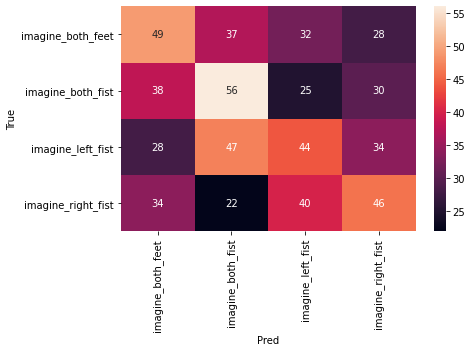

In [13]:
import seaborn as sns
import pandas as pd
import io

figure = plt.figure(figsize=(7, 5))
cm_df = pd.DataFrame(cm, columns=class_names, index=class_names)
sns.heatmap(cm_df, annot=True, fmt='g')
plt.ylabel('True')
plt.xlabel('Pred')
plt.tight_layout()
plt.savefig('runs/fcn/cm.png')
plt.show()

In [14]:
print('Number of trainable parameters')
sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of trainable parameters


3542020

In [15]:
512

512